<a href="https://colab.research.google.com/github/ElMartinez31/Data_Science/blob/main/Course_Pytorch_org.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

COURS de PYTORCH.ORG

**Working with data**

PyTorch has two primitives to work with data: torch.utils.data.DataLoader and torch.utils.data.Dataset. Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset.

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

PyTorch offers domain-specific libraries such as TorchText, TorchVision, and TorchAudio, all of which include datasets. For this tutorial, we will be using a TorchVision dataset.

In [ ]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100%|██████████| 26.4M/26.4M [00:01<00:00, 17.8MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 305kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.54MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 12.1MB/s]


We pass the Dataset as an argument to DataLoader. This wraps an iterable over our dataset, and supports automatic batching, sampling, shuffling and multiprocess data loading. Here we define a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.

In [ ]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


1. Convention de forme (shape) en PyTorch
En PyTorch, les tenseurs ont des formes (shapes) spécifiques:

(4,) signifie un tenseur 1D avec 4 éléments (vecteur)

(4, 1) signifie un tenseur 2D avec 4 lignes et 1 colonne (matrice colonne)

2. Compatibilité avec les opérations matricielles
La plupart des opérations de réseaux de neurones s'attendent à des entrées 2D:

Les couches linéaires (nn.Linear) attendent des inputs de forme (batch_size, nb_features)

Dans votre cas, vous avez 1 feature et batch_size=4, donc (4, 1)

3. Différenciation claire entre batch et features
Avec (4, 1):

4 = nombre d'échantillons (batch size)

1 = nombre de features (caractéristiques)

In [ ]:
X = torch.tensor([1.0, 2.0, 3.0, 4.0], dtype=torch.float32).reshape(4, 1)
Y = torch.tensor([2.0, 4.0, 6.0, 8.0], dtype=torch.float32).unsqueeze()
# equivalent dans le cas ou on on est à 1 dans le reshape (4,) ->(4,1) <=> unsqueeze()

**Creating Models**

To define a neural network in PyTorch, we create a class that inherits from nn.Module. We define the layers of the network in the __init__ function and specify how data will pass through the network in the forward function. To accelerate operations in the neural network, we move it to the accelerator such as CUDA, MPS, MTIA, or XPU. If the current accelerator is available, we will use it. Otherwise, we use the CPU.

In [ ]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


**Optimizing the Model Parameters**

To train a model, we need a loss function and an optimizer.

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and backpropagates the prediction error to adjust the model’s parameters.

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

We also check the model’s performance against the test dataset to ensure it is learning.

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

The training process is conducted over several iterations (epochs). During each epoch, the model learns parameters to make better predictions. We print the model’s accuracy and loss at each epoch; we’d like to see the accuracy increase and the loss decrease with every epoch.

In [ ]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.301716  [   64/60000]
loss: 2.297232  [ 6464/60000]
loss: 2.266123  [12864/60000]
loss: 2.258641  [19264/60000]
loss: 2.246509  [25664/60000]
loss: 2.203865  [32064/60000]
loss: 2.220433  [38464/60000]
loss: 2.174932  [44864/60000]
loss: 2.179498  [51264/60000]
loss: 2.140913  [57664/60000]
Test Error: 
 Accuracy: 44.0%, Avg loss: 2.135526 

Epoch 2
-------------------------------
loss: 2.148561  [   64/60000]
loss: 2.146321  [ 6464/60000]
loss: 2.073134  [12864/60000]
loss: 2.096512  [19264/60000]
loss: 2.051471  [25664/60000]
loss: 1.973335  [32064/60000]
loss: 2.022323  [38464/60000]
loss: 1.924463  [44864/60000]
loss: 1.937101  [51264/60000]
loss: 1.866797  [57664/60000]
Test Error: 
 Accuracy: 54.2%, Avg loss: 1.858901 

Epoch 3
-------------------------------
loss: 1.890849  [   64/60000]
loss: 1.868501  [ 6464/60000]
loss: 1.732501  [12864/60000]
loss: 1.792914  [19264/60000]
loss: 1.690320  [25664/60000]
loss: 1.620002  [32064/600

**Saving Models**

A common way to save a model is to serialize the internal state dictionary (containing the model parameters)

In [ ]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


**Loading Models**

The process for loading a model includes re-creating the model structure and loading the state dictionary into it.

In [ ]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth", weights_only=True))

<All keys matched successfully>

This model can now be used to make predictions.

In [ ]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


**Tensors**

Tensors are a specialized data structure that are very similar to arrays and matrices. In PyTorch, we use tensors to encode the inputs and outputs of a model, as well as the model’s parameters.

Tensors are similar to NumPy’s ndarrays, except that tensors can run on GPUs or other hardware accelerators. In fact, tensors and NumPy arrays can often share the same underlying memory, eliminating the need to copy data (see Bridge with NumPy). Tensors are also optimized for automatic differentiation (we’ll see more about that later in the Autograd section). If you’re familiar with ndarrays, you’ll be right at home with the Tensor API. If not, follow along!

**Initializing a Tensor**

Tensors can be initialized in various ways. Take a look at the following examples:

In [ ]:
#Directly from data
import numpy as np

#Tensors can be created directly from data. The data type is automatically inferred.

data = [[1, 2],[3, 4]]
x_data = torch.tensor(data)


#From a NumPy array

#Tensors can be created from NumPy arrays (and vice versa - see Bridge with NumPy).

np_array = np.array(data)
x_np = torch.from_numpy(np_array)


# From another tensor
x_ones = torch.ones_like(x_data) # retains the properties of x_data
print(f"Ones Tensor: \n {x_ones} \n")

x_rand = torch.rand_like(x_data, dtype=torch.float) # overrides the datatype of x_data
print(f"Random Tensor: \n {x_rand} \n")


#with random or constant value
shape = (2,3,)
rand_tensor = torch.rand(shape)
ones_tensor = torch.ones(shape)
zeros_tensor = torch.zeros(shape)

print(f"Random Tensor: \n {rand_tensor} \n")
print(f"Ones Tensor: \n {ones_tensor} \n")
print(f"Zeros Tensor: \n {zeros_tensor}")

Ones Tensor: 
 tensor([[1, 1],
        [1, 1]]) 

Random Tensor: 
 tensor([[0.6270, 0.8365],
        [0.8253, 0.1070]]) 

Random Tensor: 
 tensor([[0.6632, 0.7098, 0.3890],
        [0.4169, 0.3540, 0.0777]]) 

Ones Tensor: 
 tensor([[1., 1., 1.],
        [1., 1., 1.]]) 

Zeros Tensor: 
 tensor([[0., 0., 0.],
        [0., 0., 0.]])


**Attributes of a Tensor**

Tensor attributes describe their shape, datatype, and the device on which they are stored.


In [ ]:

tensor = torch.rand(3,4)

print(f"Shape of tensor: {tensor.shape}")
print(f"Datatype of tensor: {tensor.dtype}")
print(f"Device tensor is stored on: {tensor.device}")

Shape of tensor: torch.Size([3, 4])
Datatype of tensor: torch.float32
Device tensor is stored on: cpu


**Operations on Tensors**

Over 1200 tensor operations, including arithmetic, linear algebra, matrix manipulation (transposing, indexing, slicing), sampling and more are comprehensively described here.

Each of these operations can be run on the CPU and Accelerator such as CUDA, MPS, MTIA, or XPU. If you’re using Colab, allocate an accelerator by going to Runtime > Change runtime type > GPU.

By default, tensors are created on the CPU. We need to explicitly move tensors to the accelerator using .to method (after checking for accelerator availability). Keep in mind that copying large tensors across devices can be expensive in terms of time and memory!

In [ ]:
# https://pytorch.org/docs/stable/torch.html

# We move our tensor to the current accelerator if available
if torch.accelerator.is_available():
    tensor = tensor.to(torch.accelerator.current_accelerator())

Standard numpy-like indexing and slicing:

In [ ]:
tensor = torch.ones(4, 4)
print(f"First row: {tensor[0]}")
print(f"First column: {tensor[:, 0]}")
print(f"Last column: {tensor[..., -1]}")
tensor[:,1] = 0
print(tensor)

First row: tensor([1., 1., 1., 1.])
First column: tensor([1., 1., 1., 1.])
Last column: tensor([1., 1., 1., 1.])
tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])


**Joining tensors**

 You can use torch.cat to concatenate a sequence of tensors along a given dimension. See also torch.stack, another tensor joining operator that is subtly different from torch.cat.

In [ ]:
t1 = torch.cat([tensor, tensor, tensor], dim=1)
print(t1)



tensor([[1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.]])


**Arithmetic Operations**

In [ ]:
# This computes the matrix multiplication between two tensors. y1, y2, y3 will have the same value
# ``tensor.T`` returns the transpose of a tensor
y1 = tensor @ tensor.T
y2 = tensor.matmul(tensor.T)

y3 = torch.rand_like(y1)
torch.matmul(tensor, tensor.T, out=y3)


# This computes the element-wise product. z1, z2, z3 will have the same value
z1 = tensor * tensor
z2 = tensor.mul(tensor)

z3 = torch.rand_like(tensor)
torch.mul(tensor, tensor, out=z3)

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])

**Squeeze() & unsqueeze()**

En Python, avec la bibliothèque PyTorch, les fonctions squeeze() et unsqueeze() sont utilisées pour modifier les dimensions d'un tenseur en supprimant ou en ajoutant des dimensions de taille 1

In [ ]:
import torch

x = torch.rand(3, 2)  # Tensor de shape (3, 2)

# 1. Redimensionner x en (6,) (vecteur 1D)
x_reshaped = x.reshape([6])

# 2. Ajouter une dimension à x pour obtenir (3, 2, 1)
x_unsqueezed = torch.unsqueeze(x, dim=2)#Ajoute une dimension à l'index dim=2, transformant (3, 2) en (3, 2, 1).

# 3. Enlever toutes les dimensions de taille 1 de x_unsqueezed
x_squeezed = x_unsqueezed.squeeze()

# Afficher les shapes
print("x_reshaped:", x_reshaped.shape)
print("x_unsqueezed:", x_unsqueezed.shape)
print("x_squeezed:", x_squeezed.shape)

In [ ]:
#Conversion Tensor → NumPy (tensor.numpy())

#Nota: cette opération crée une vue partagée en mémoire si le tensor est sur CPU (modifier l'un affecte l'autre).
# Pour éviter cela, on peut utiliser .clone() :

my_tensor = torch.ones((2,2), dtype = torch.float32)
array_np = my_tensor.clone().numpy()  # Copie indépendante
#better than just my_tensor.numpy()

# NumPy → Tensor et a l'inverse:
torch.from_numpy(my_array) # si on veut une vue partagée
torch.tensor(my_array) # si on veut une copie indépendante

# la vue partagée est pour plus de performances, mais est risquée (modifier l'un peut modifier l'autre)

**Single-element tensors:**

 If you have a one-element tensor, for example by aggregating all values of a tensor into one value, you can convert it to a Python numerical value using item():

In [ ]:
agg = tensor.sum()
agg_item = agg.item()
print(agg_item, type(agg_item))

12.0 <class 'float'>


**Datasets & DataLoaders**

Code for processing data samples can get messy and hard to maintain; we ideally want our dataset code to be decoupled from our model training code for better readability and modularity. PyTorch provides two data primitives: torch.utils.data.DataLoader and torch.utils.data.Dataset that allow you to use pre-loaded datasets as well as your own data. Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples.

PyTorch domain libraries provide a number of pre-loaded datasets (such as FashionMNIST) that subclass torch.utils.data.Dataset and implement functions specific to the particular data. They can be used to prototype and benchmark your model. You can find them here: Image Datasets, Text Datasets, and Audio Datasets

**Loading a Dataset**

Here is an example of how to load the Fashion-MNIST dataset from TorchVision. Fashion-MNIST is a dataset of Zalando’s article images consisting of 60,000 training examples and 10,000 test examples. Each example comprises a 28×28 grayscale image and an associated label from one of 10 classes.

We load the FashionMNIST Dataset with the following parameters:
root is the path where the train/test data is stored,

train specifies training or test dataset,

download=True downloads the data from the internet if it’s not available at root.

transform and target_transform specify the feature and label transformations

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

**Iterating and Visualizing the Dataset**

We can index Datasets manually like a list: training_data[index]. We use matplotlib to visualize some samples in our training data.

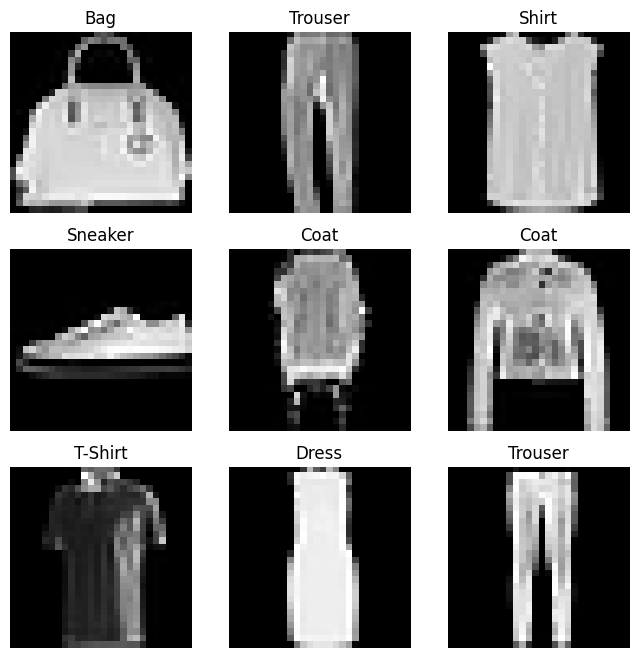

In [ ]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

**Creating a Custom Dataset**

A custom Dataset class must implement three functions: __init__, __len__, and __getitem__. Take a look at this implementation; the FashionMNIST images are stored in a directory img_dir, and their labels are stored separately in a CSV file annotations_file.

In the next sections, we’ll break down what’s happening in each of these functions.

In [ ]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

The __init__ function is run once when instantiating the Dataset object. We initialize the directory containing the images, the annotations file, and both transforms (covered in more detail in the next section).

The __getitem__ function loads and returns a sample from the dataset at the given index idx. Based on the index, it identifies the image’s location on disk, converts that to a tensor using read_image, retrieves the corresponding label from the csv data in self.img_labels, calls the transform functions on them (if applicable), and returns the tensor image and corresponding label in a tuple.

**Preparing your data for training with DataLoaders**

The Dataset retrieves our dataset’s features and labels one sample at a time. While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s multiprocessing to speed up data retrieval.

DataLoader is an iterable that abstracts this complexity for us in an easy API.

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

**Iterate through the DataLoader**

We have loaded that dataset into the DataLoader and can iterate through the dataset as needed. Each iteration below returns a batch of train_features and train_labels (containing batch_size=64 features and labels respectively). Because we specified shuffle=True, after we iterate over all batches the data is shuffled (for finer-grained control over the data loading order, take a look at Samplers).

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


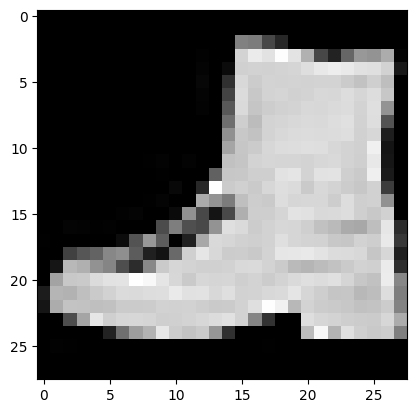

Label: 9


In [ ]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

**Transforms**


Data does not always come in its final processed form that is required for training machine learning algorithms. We use transforms to perform some manipulation of the data and make it suitable for training.

All TorchVision datasets have two parameters -transform to modify the features and target_transform to modify the labels - that accept callables containing the transformation logic. The torchvision.transforms module offers several commonly-used transforms out of the box.

The FashionMNIST features are in PIL Image format, and the labels are integers. For training, we need the features as normalized tensors, and the labels as one-hot encoded tensors. To make these transformations, we use ToTensor and Lambda.

In [ ]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda


#train=True : charge l'ensemble d'entraînement (60 000 images)
#train=False : charge l'ensemble de test (10 000 images)
ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)


#Lambda crée une fonction personnalisée pour transformer les étiquettes

#torch.zeros(10, dtype=torch.float) crée un vecteur de 10 zéros (car FashionMNIST a 10 classes)

#.scatter_(0, torch.tensor(y), value=1) :

#0 : dimension le long de laquelle scatter opère

#torch.tensor(y) : position où mettre la valeur 1 (l'index de la classe)

#value=1 : la valeur à insérer ( signifie qu'on insère la valeur 1.0 aux positions spécifiées)

#Exemple concret
#Si l'étiquette originale est 2 (pullover), la transformation donne :
#[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]

**ToTensor()**

ToTensor converts a PIL image or NumPy ndarray into a FloatTensor. and scales the image’s pixel intensity values in the range [0., 1.]

**Lambda Transforms**

Lambda transforms apply any user-defined lambda function. Here, we define a function to turn the integer into a one-hot encoded tensor. It first creates a zero tensor of size 10 (the number of labels in our dataset) and calls scatter_ which assigns a value=1 on the index as given by the label y.

In [ ]:
target_transform = Lambda(lambda y: torch.zeros(
    10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))

**Build the Neural Network**



Neural networks comprise of layers/modules that perform operations on data. The torch.nn namespace provides all the building blocks you need to build your own neural network. Every module in PyTorch subclasses the nn.Module. A neural network is a module itself that consists of other modules (layers). This nested structure allows for building and managing complex architectures easily.

In the following sections, we’ll build a neural network to classify images in the FashionMNIST dataset.

In [ ]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

Get Device for Training

We want to be able to train our model on an accelerator such as CUDA, MPS, MTIA, or XPU. If the current accelerator is available, we will use it. Otherwise, we use the CPU.

In [ ]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


Define the Class

We define our neural network by subclassing nn.Module, and initialize the neural network layers in __init__. Every nn.Module subclass implements the operations on input data in the forward method.

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Model Layers

Let’s break down the layers in the FashionMNIST model. To illustrate it, we will take a sample minibatch of 3 images of size 28x28 and see what happens to it as we pass it through the network.

In [ ]:
input_image = torch.rand(3,28,28)
print(input_image.size())

torch.Size([3, 28, 28])


nn.Flatten

We initialize the nn.Flatten layer to convert each 2D 28x28 image into a contiguous array of 784 pixel values ( the minibatch dimension (at dim=0) is maintained).

In [ ]:
flatten = nn.Flatten()
flat_image = flatten(input_image)
print(flat_image.size())

torch.Size([3, 784])


nn.Linear

The linear layer is a module that applies a linear transformation on the input using its stored weights and biases.

In [ ]:
layer1 = nn.Linear(in_features=28*28, out_features=20)
hidden1 = layer1(flat_image)
print(hidden1.size())

torch.Size([3, 20])


nn.ReLU

Non-linear activations are what create the complex mappings between the model’s inputs and outputs. They are applied after linear transformations to introduce nonlinearity, helping neural networks learn a wide variety of phenomena.

In this model, we use nn.ReLU between our linear layers, but there’s other activations to introduce non-linearity in your model.

In [ ]:
print(f"Before ReLU: {hidden1}\n\n")
hidden1 = nn.ReLU()(hidden1)
print(f"After ReLU: {hidden1}")

Before ReLU: tensor([[ 0.4745,  0.2394, -0.0770,  0.1901,  0.4205,  0.1923,  0.5597,  0.2430,
          0.4697,  0.5056,  0.3059, -0.5644, -0.1143, -0.2776,  0.0369, -0.0232,
         -0.2621,  0.1999,  0.4987,  0.1413],
        [ 0.4863,  0.4530,  0.1300, -0.0395,  0.1737,  0.0113,  0.3435,  0.4540,
          0.0254,  0.4565,  0.3022, -0.5908,  0.0592, -0.2020,  0.0073, -0.2207,
         -0.1962, -0.1578,  0.5897,  0.2864],
        [ 0.2334,  0.4661, -0.4066,  0.0346,  0.4135, -0.0947,  0.5705,  0.1735,
          0.0399,  0.7771,  0.6903, -0.5239, -0.2024,  0.0716,  0.0165,  0.2621,
         -0.4874, -0.1698,  0.5968,  0.1154]], grad_fn=<AddmmBackward0>)


After ReLU: tensor([[0.4745, 0.2394, 0.0000, 0.1901, 0.4205, 0.1923, 0.5597, 0.2430, 0.4697,
         0.5056, 0.3059, 0.0000, 0.0000, 0.0000, 0.0369, 0.0000, 0.0000, 0.1999,
         0.4987, 0.1413],
        [0.4863, 0.4530, 0.1300, 0.0000, 0.1737, 0.0113, 0.3435, 0.4540, 0.0254,
         0.4565, 0.3022, 0.0000, 0.0592, 0.0000, 0.00

nn.Sequential

nn.Sequential is an ordered container of modules. The data is passed through all the modules in the same order as defined. You can use sequential containers to put together a quick network like seq_modules.

In [ ]:
seq_modules = nn.Sequential(
    flatten,
    layer1,
    nn.ReLU(),
    nn.Linear(20, 10)
)
input_image = torch.rand(3,28,28)
logits = seq_modules(input_image)

nn.Softmax

The last linear layer of the neural network returns logits - raw values in [-infty, infty] - which are passed to the nn.Softmax module. The logits are scaled to values [0, 1] representing the model’s predicted probabilities for each class. dim parameter indicates the dimension along which the values must sum to 1.

In [ ]:
softmax = nn.Softmax(dim=1)
pred_probab = softmax(logits)

In [ ]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[-0.0205, -0.0194, -0.0117,  ...,  0.0278, -0.0304,  0.0295],
        [-0.0309, -0.0012, -0.0211,  ..., -0.0320, -0.0193, -0.0032]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([-0.0043,  0.0309], grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[ 0.0318,  0.0406,  0.0045,  ...,  0.0208, -0.0026, -0.0013],
        [ 0.0117,  0.0422,  0.0125,  ...,  0.0263, -0.0253,  0.0105]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.bias | 

**Automatic Differentiation with torch.autograd**

When training neural networks, the most frequently used algorithm is back propagation. In this algorithm, parameters (model weights) are adjusted according to the gradient of the loss function with respect to the given parameter.

To compute those gradients, PyTorch has a built-in differentiation engine called torch.autograd. It supports automatic computation of gradient for any computational graph.

Consider the simplest one-layer neural network, with input x, parameters w and b, and some loss function. It can be defined in PyTorch in the following manner:

In [ ]:
import torch

x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

Tensors, Functions and Computational graph

This code defines the following computational graph:

In this network, w and b are parameters, which we need to optimize. Thus, we need to be able to compute the gradients of loss function with respect to those variables. In order to do that, we set the requires_grad property of those tensors.

Nota: You can set the value of requires_grad when creating a tensor, or later by using x.requires_grad_(True) method.


A function that we apply to tensors to construct computational graph is in fact an object of class Function. This object knows how to compute the function in the forward direction, and also how to compute its derivative during the backward propagation step. A reference to the backward propagation function is stored in grad_fn property of a tensor. You can find more information of Function in the documentation.

In [ ]:
print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")

Gradient function for z = <AddBackward0 object at 0x7a17f3fe7e20>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x7a17f3fe7700>


Computing Gradients
To optimize weights of parameters in the neural network, we need to compute the derivatives of our loss function with respect to parameters, namely, we need

∂w/∂loss

∂b/∂loss

  under some fixed values of x and y. To compute those derivatives, we call loss.backward(), and then retrieve the values from w.grad and b.grad:



In [ ]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.0734, 0.0243, 0.2148],
        [0.0734, 0.0243, 0.2148],
        [0.0734, 0.0243, 0.2148],
        [0.0734, 0.0243, 0.2148],
        [0.0734, 0.0243, 0.2148]])
tensor([0.0734, 0.0243, 0.2148])


Nota:
We can only obtain the grad properties for the leaf nodes of the computational graph, which have requires_grad property set to True. For all other nodes in our graph, gradients will not be available.

We can only perform gradient calculations using backward once on a given graph, for performance reasons. If we need to do several backward calls on the same graph, we need to pass retain_graph=True to the backward call.

Disabling Gradient Tracking

By default, all tensors with requires_grad=True are tracking their computational history and support gradient computation. However, there are some cases when we do not need to do that, for example, when we have trained the model and just want to apply it to some input data, i.e. we only want to do forward computations through the network. We can stop tracking computations by surrounding our computation code with torch.no_grad() block:

In [ ]:
z = torch.matmul(x, w)+b
print(z.requires_grad)

with torch.no_grad():
    z = torch.matmul(x, w)+b
print(z.requires_grad)


#Another way to achieve the same result is to use the detach() method on the tensor:

z = torch.matmul(x, w)+b
z_det = z.detach()
print(z_det.requires_grad)

There are reasons you might want to disable gradient tracking:
To mark some parameters in your neural network as frozen parameters.

To speed up computations when you are only doing forward pass, because computations on tensors that do not track gradients would be more efficient.

More on Computational Graphs

Conceptually, autograd keeps a record of data (tensors) and all executed operations (along with the resulting new tensors) in a directed acyclic graph (DAG) consisting of Function objects. In this DAG, leaves are the input tensors, roots are the output tensors. By tracing this graph from roots to leaves, you can automatically compute the gradients using the chain rule.

In a forward pass, autograd does two things simultaneously:

run the requested operation to compute a resulting tensor

maintain the operation’s gradient function in the DAG.

The backward pass kicks off when .backward() is called on the DAG root. autograd then:

computes the gradients from each .grad_fn,

accumulates them in the respective tensor’s .grad attribute

using the chain rule, propagates all the way to the leaf tensors.

Nota:
DAGs are dynamic in PyTorch An important thing to note is that the graph is recreated from scratch; after each .backward() call, autograd starts populating a new graph. This is exactly what allows you to use control flow statements in your model; you can change the shape, size and operations at every iteration if needed.

Optimizing Model Parameters


Now that we have a model and data it’s time to train, validate and test our model by optimizing its parameters on our data. Training a model is an iterative process; in each iteration the model makes a guess about the output, calculates the error in its guess (loss), collects the derivatives of the error with respect to its parameters (as we saw in the previous section), and optimizes these parameters using gradient descent. For a more detailed walkthrough of this process, check out this video on backpropagation from 3Blue1Brown.

Prerequisite Code

We load the code from the previous sections on Datasets & DataLoaders and Build Model.

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()

Hyperparameters

Hyperparameters are adjustable parameters that let you control the model optimization process. Different hyperparameter values can impact model training and convergence rates (read more about hyperparameter tuning)

We define the following hyperparameters for training:
Number of Epochs - the number times to iterate over the dataset

Batch Size - the number of data samples propagated through the network before the parameters are updated

Learning Rate - how much to update models parameters at each batch/epoch. Smaller values yield slow learning speed, while large values may result in unpredictable behavior during training.



In [ ]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

Optimization Loop

Once we set our hyperparameters, we can then train and optimize our model with an optimization loop. Each iteration of the optimization loop is called an epoch.

Each epoch consists of two main parts:
The Train Loop - iterate over the training dataset and try to converge to optimal parameters.

The Validation/Test Loop - iterate over the test dataset to check if model performance is improving.

Let’s briefly familiarize ourselves with some of the concepts used in the training loop. Jump ahead to see the Full Implementation of the optimization loop.

Loss Function

When presented with some training data, our untrained network is likely not to give the correct answer. Loss function measures the degree of dissimilarity of obtained result to the target value, and it is the loss function that we want to minimize during training. To calculate the loss we make a prediction using the inputs of our given data sample and compare it against the true data label value.

Common loss functions include nn.MSELoss (Mean Square Error) for regression tasks, and nn.NLLLoss (Negative Log Likelihood) for classification. nn.CrossEntropyLoss combines nn.LogSoftmax and nn.NLLLoss.

We pass our model’s output logits to nn.CrossEntropyLoss, which will normalize the logits and compute the prediction error.

In [ ]:
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

Optimizer

Optimization is the process of adjusting model parameters to reduce model error in each training step. Optimization algorithms define how this process is performed (in this example we use Stochastic Gradient Descent). All optimization logic is encapsulated in the optimizer object. Here, we use the SGD optimizer; additionally, there are many different optimizers available in PyTorch such as ADAM and RMSProp, that work better for different kinds of models and data.

We initialize the optimizer by registering the model’s parameters that need to be trained, and passing in the learning rate hyperparameter.

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Inside the training loop, optimization happens in three steps:
Call optimizer.zero_grad() to reset the gradients of model parameters. Gradients by default add up; to prevent double-counting, we explicitly zero them at each iteration.

Backpropagate the prediction loss with a call to loss.backward(). PyTorch deposits the gradients of the loss w.r.t. each parameter.

Once we have our gradients, we call optimizer.step() to adjust the parameters by the gradients collected in the backward pass.

Full Implementation

We define train_loop that loops over our optimization code, and test_loop that evaluates the model’s performance against our test data.

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)#Retourne la taille totale du dataset sous-jacent (par exemple, 60 000 images pour MNIST entraînement).
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

We initialize the loss function and optimizer, and pass it to train_loop and test_loop. Feel free to increase the number of epochs to track the model’s improving performance.

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Save and Load the Model


In this section we will look at how to persist model state with saving, loading and running model predictions.

In [ ]:
import torch
import torchvision.models as models


Saving and Loading Model Weights

PyTorch models store the learned parameters in an internal state dictionary, called state_dict. These can be persisted via the torch.save method:

In [ ]:
model = models.vgg16(weights='IMAGENET1K_V1')
torch.save(model.state_dict(), 'model_weights.pth')

https://pytorch.org/tutorials/beginner/basics/saveloadrun_tutorial.html